In [1]:
import geopandas as gp
import pandas as pd
from matplotlib import cm
import matplotlib.colors as clr
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import os

# North Carolina Congressional District Prison Gerrymandering Estimated Impact

## Background:
- We received a request for analysis of prison gerrymandering on NC's congressional districts

## Approach:
- Load in NC BAF
- Load in NC counterfactual prisoner-adjusted dataset (using the county of residence data)
- Join the two and aggregate to districts
- Join the district geometry for plotting
- Clean the dataframe
- Export the file as a CSV.

## Links to datasets used:
- [North Carolina 118th CD BAF and Districts](https://redistrictingdatahub.org/dataset/118th-congressional-districts-nov-2022-election-active-jan-2023-jan-2025/)
- [North Carolina Block-Level Prisoner-Adjusted Dataset](https://redistrictingdatahub.org/dataset/north-carolina-blocklevel-2020-counterfactual-prisoner-adjusted-redistricting-data-with-aggregations-to-state-legislative-districts/)

In [2]:
# Load in Needed Files
cong_baf = pd.read_csv("ADD YOUR PATH HERE")
cong_dist = gp.read_file("ADD YOUR PATH HERE")

# Clean Files
cong_baf = cong_baf[cong_baf["STATE"]=="NC"]
cong_dist = cong_dist[cong_dist["STATE"]=="NC"]
cong_baf["GEOID20"] = cong_baf["GEOID20"].astype(int)

# Load in Counterfactual Dataset
residence_county = pd.read_csv("ADD YOUR PATH HERE")

# Join Data
joined_residence = pd.merge(cong_baf, residence_county, left_on = "GEOID20",right_on = "blockid", indicator = True)

# Aggregate to CD
joined_residence_counties = joined_residence.groupby("CONG118").sum()
joined_residence_counties.reset_index(inplace = True, drop = False)

/var/folders/1t/0q4w6hm92mg_zxd84dfxmq3m0000gn/T/ipykernel_63920/114856169.py:17: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  joined_residence_counties = joined_residence.groupby("CONG118").sum()


In [3]:
# Clean to join to district shapefiles
joined_residence_counties["CONG118"] = joined_residence_counties["CONG118"].apply(lambda x: x.split("-")[0]+"-"+x.split("-")[1].zfill(2))

# Join, remove unwanted columns and sort
residence_counties_shp = gp.GeoDataFrame(pd.merge(joined_residence_counties, cong_dist, how = "outer", on = "CONG118"))
residence_counties_shp.drop(["GEOID20","blockid","district_h", "district_s"], axis = 1, inplace = True)
residence_counties_shp.sort_values("CONG118", inplace = True)

# Add a difference column
for group in ['white', 'black', 'total', 'other']:
    residence_counties_shp["adj"+group+"_diff"] = residence_counties_shp["adj"+group] - residence_counties_shp[group]
    
# Clean up order
residence_counties_shp = residence_counties_shp[['CONG118', 'total', 'white', 'black', 'other', 'adjtotal', 'adjwhite',
   'adjblack', 'adjother',
   'adjwhite_diff', 'adjblack_diff', 'adjtotal_diff', 'adjother_diff','geometry']]

# Make Maps

In [4]:
min_val = min(residence_counties_shp['adjtotal_diff'])
max_val = max(residence_counties_shp['adjtotal_diff'])

zero_mark = -min_val/(max_val-min_val)

# Define a colormap (doing this as the default red color map was too light for white text)
reds = cm.get_cmap('Reds',256)
my_cmap = clr.LinearSegmentedColormap.from_list('reds',[(0,"purple"),(zero_mark,"white"),(1,"orange")], N=256)


In [5]:
centroid_dict = {'NC-01': (-77.35339560705656, 36.06360820071993),
 'NC-02': (-78.59550997649255, 35.85),
 'NC-03': (-77.5, 35),
 'NC-04': (-78.99448508942275, 36.18318753648321),
 'NC-05': (-81.07664268575724, 36.224003555796735),
 'NC-06': (-79.69609830342168, 36.259586166112015),
 'NC-07': (-78.50297295817832, 34.25),
 'NC-08': (-80.23374861345678, 35.3054126321878),
 'NC-09': (-79.41518712408258, 35.391765296981696),
 'NC-10': (-81.34619244967233, 35.5),
 'NC-11': (-82.94274084205087, 35.43975706048412),
 'NC-12': (-80.75418542131158, 35.348463959175625),
 'NC-13': (-78.48145152868561, 35.497678665223596),
 'NC-14': (-81.1, 35.175)}

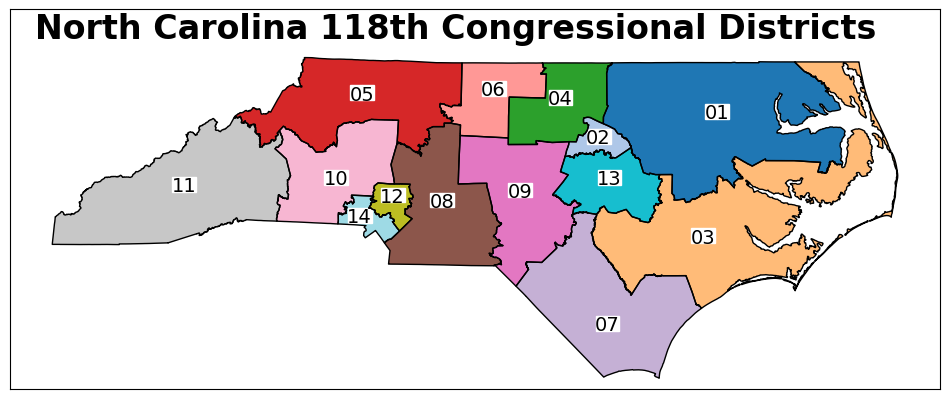

In [7]:
ax = residence_counties_shp.plot(figsize = (12,8), linewidth = .25, column = "CONG118", cmap = "tab20")
residence_counties_shp.boundary.plot(ax =ax, figsize = (12,8), color = "black", linewidth = 1)
residence_counties_shp.apply(lambda x: ax.add_patch(Rectangle(centroid_dict[x["CONG118"]],-.125,.125,linewidth=1,edgecolor='w',facecolor='white') ), axis=1, )
residence_counties_shp.apply(lambda x: ax.add_patch(Rectangle(centroid_dict[x["CONG118"]],.125,.125,linewidth=1,edgecolor='w',facecolor='white') ), axis=1, )

residence_counties_shp.apply(lambda x: ax.annotate(text=x["CONG118"].split("-")[1], xy=centroid_dict[x["CONG118"]], ha='center', fontsize = 14, color = "black"), axis=1, )
ax.tick_params(left = False, right = False, labelleft = False, labelright = False, labelbottom = False, bottom = False)

ax.annotate(text = "North Carolina 118th Congressional Districts", xy = (-84.5, 36.75), fontsize = 24, fontweight = "bold")
ax.set_ylim([33.75, 37])
ax.figure.savefig("./nc_118_dist.jpg", dpi = 350, bbox_inches = "tight")

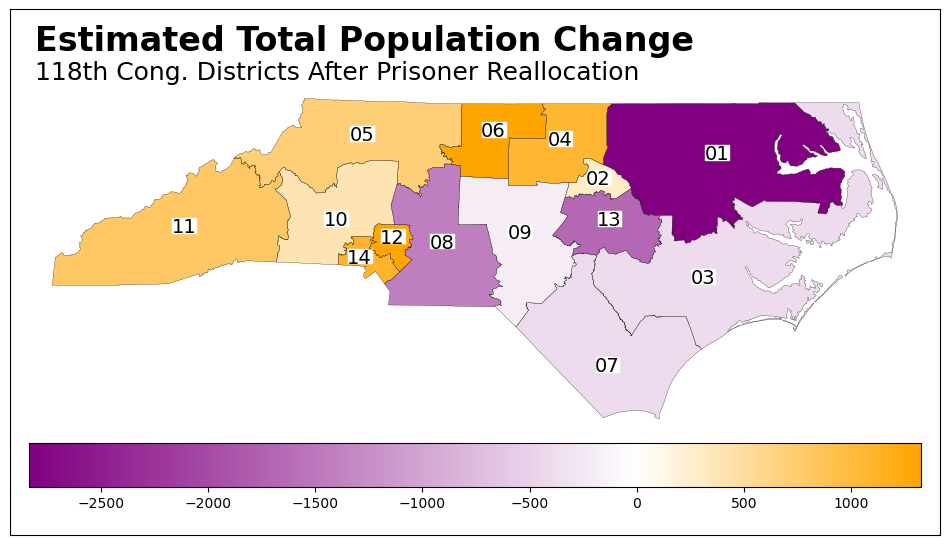

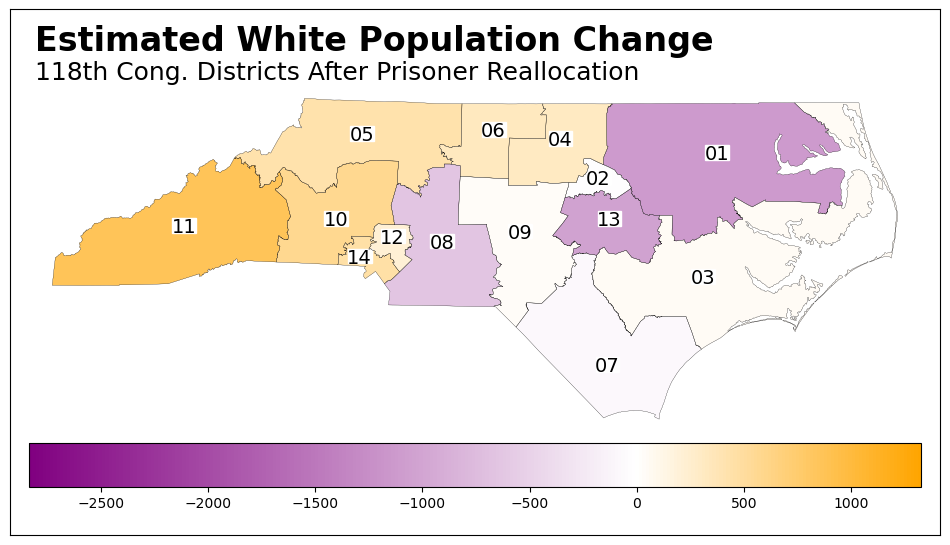

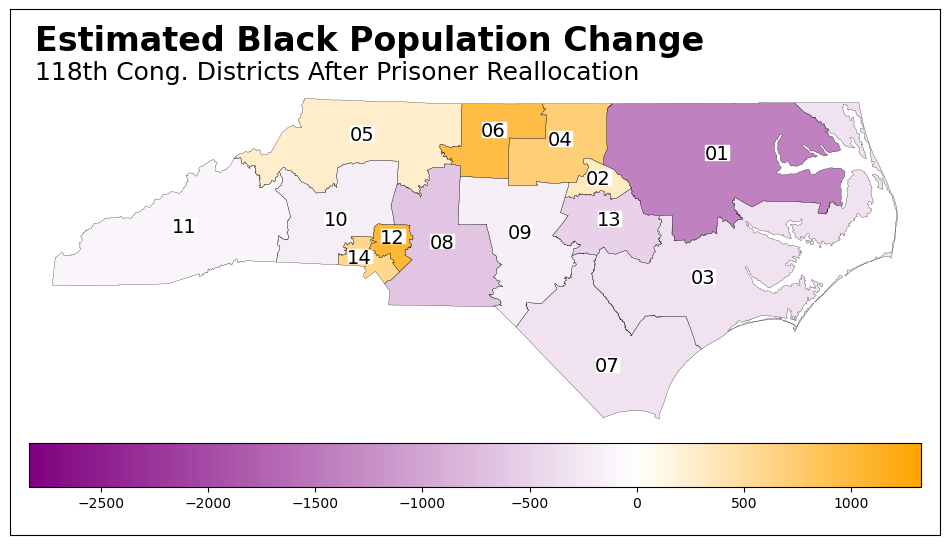

In [8]:
vmin = min(residence_counties_shp['total'])
vmax = max(residence_counties_shp['total'])

for group in ['total','white', 'black']:
    ax = residence_counties_shp.plot( column = "adj"+group+"_diff",  vmin = min_val, vmax = max_val, legend = True, legend_kwds={'orientation':'horizontal','shrink':.96, "pad": -.15}, cmap = my_cmap, edgecolor = "black", linewidth = .05, figsize = (12,8))
    residence_counties_shp.boundary.plot(ax = ax,edgecolor = "black", linewidth = .15)
    residence_counties_shp.apply(lambda x: ax.add_patch(Rectangle(centroid_dict[x["CONG118"]],-.125,.125,linewidth=1,edgecolor='w',facecolor='white') ), axis=1, )
    residence_counties_shp.apply(lambda x: ax.add_patch(Rectangle(centroid_dict[x["CONG118"]],.125,.125,linewidth=1,edgecolor='w',facecolor='white') ), axis=1, )

    residence_counties_shp.apply(lambda x: ax.annotate(text=x["CONG118"].split("-")[1], xy=centroid_dict[x["CONG118"]], ha='center', fontsize = 14, color = "black"), axis=1, )

    fig = ax.figure
    cb_ax = fig.axes[1]
    cb_ax.tick_params(labelsize = 10)
    
    ax.set_ylim([32.85, 37.35])
    
    ax.tick_params(left = False, right = False, labelleft = False, labelright = False, labelbottom = False, bottom = False)
    
    ax.annotate(text = "Estimated " + group.title() + " Population Change", xy = (-84.5, 37), fontsize = 24, fontweight = "bold")
    ax.annotate(text = "118th Cong. Districts After Prisoner Reallocation", xy = (-84.5, 36.75), fontsize = 18)

    ax.figure.savefig("./nc_adj"+group+"_diff.jpg", dpi = 350, bbox_inches = "tight")

# Clean and Export DataFrame

In [9]:
residence_counties_export = residence_counties_shp.copy(deep = True)
residence_counties_export.drop(["geometry"], axis = 1, inplace = True)

for col in [i for i in residence_counties_shp.columns if "adj" in i]:
    print(col)
    residence_counties_export[col] = residence_counties_export[col].round(1)
    
for col in list(residence_counties_export.columns):
    if col != "CONG118":
        residence_counties_export[col] = residence_counties_export[col].map('{:,}'.format)

adjtotal
adjwhite
adjblack
adjother
adjwhite_diff
adjblack_diff
adjtotal_diff
adjother_diff


In [10]:
residence_counties_export = residence_counties_export[['CONG118', 'total', 'white', 'black', 'other', 'adjtotal', 'adjwhite', 'adjblack', 'adjother', 'adjtotal_diff', 'adjwhite_diff', 'adjblack_diff', 'adjother_diff']]

if not os.path.exists("./nc_118_prison_gerrymandering_estimates/"):
    os.mkdir("./nc_118_prison_gerrymandering_estimates/")

residence_counties_export.to_csv("./nc_118_prison_gerrymandering_estimates/nc_118_prison_gerrymandering_estimates.csv", index = False)